# 决策树实现鸢尾花分类    
## 1607104130 鲍骞月

### 作业内容：   

* 自己实现ID3方式建树
    * 1.加载数据,数据可视化   
    * 2.数据切分
    * 3.实现决策树类   
    * 4.模型训练   
    * 5.模型评估,计算测试集分类准确度     
* 使用sklearn中的CART方式建树   
    * 1.加载数据   
    * 2.特征选取   
    * 3.模型训练   
    * 4.模型评估，绘制分类决策边界   

### 1.自己实现ID3方式建树   

#### 1.1 加载数据，数据可视化

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from collections import Counter
from math import log

In [52]:
# 加载数据
iris = datasets.load_iris()
X = iris.data
X_s = iris.data[:, :2]
y_s = iris.target
y = iris.target.copy()

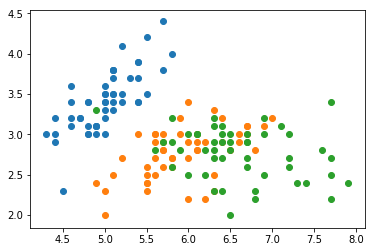

In [53]:
# 绘制数据分布情况   
plt.scatter(X_s[y_s==0,0], X_s[y_s==0,1])
plt.scatter(X_s[y_s==1,0], X_s[y_s==1,1])
plt.scatter(X_s[y_s==2,0], X_s[y_s==1,1])
plt.show()

#### 1.2 数据切分，并生成一个DataFrame

In [122]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(112, 4) (112,) (38, 4) (38,)


In [56]:
# 生成一个训练用的dataframe
features = iris.feature_names
y_train = np.reshape(y_train, (len(y_train), 1))
df = np.hstack((X_train, y_train))
labels = [i for i in features]
labels.append('label')
train_data = pd.DataFrame(df, columns=labels)
train_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,4.9,2.4,3.3,1.0,1.0
1,4.6,3.4,1.4,0.3,0.0
2,4.4,3.2,1.3,0.2,0.0
3,6.3,2.7,4.9,1.8,2.0
4,5.5,2.6,4.4,1.2,1.0


#### 1.3 实现决策树类       
使用ID3算法生成    

In [139]:
class Node:
    def __init__(self, root=True, label=None, feature_name=None, feature=None):
        self.root = root
        self.label = label
        self.feature_name = feature_name
        self.feature = feature
        self.tree = {}
        self.result = {'label:': self.label, 'feature': self.feature, 'tree': self.tree}

    def __repr__(self):
        return self.result
    
    def insert_node(self, value, node):
        self.tree[value] = node
    
    def predict(self, features):
        if self.root is True:
            return self.label
        return self.tree[features[self.feature]].predict(features)
    
class DecisionTree:
    def __init__(self, epsilon=0.1):
        self._tree = {}
        self.epsilon = epsilon
    
    # 计算信息熵
    @staticmethod
    def entropy(data):
        data_length = len(data)
        label_count = {}
        # 首先统计数据分类情况，然后计算信息熵
        for i in range(data_length):
            label = data[i][-1]
            if label not in label_count:
                label_count[label] = 0
            label_count[label] += 1
        ent = -sum([(p/data_length)*log(p/data_length, 2) for p in label_count.values()])
        return ent
    
    # 计算经验条件熵
    def condition_entropy(self, data, axis=0):
        """
        给定一个特征，计算此时的经验条件熵
        axis就是给定的特征对应的index
        """
        data_length = len(data)
        features = {}
        for i in range(data_length):
            feature = data[i][axis]
            if feature not in features:
                features[feature] = []
            features[feature].append(data[i])
        condition_ent = sum([(len(p)/data_length)*self.entropy(p) for p in features.values()])
        return condition_ent
    
    # 计算信息增益 
    @staticmethod
    def gain(entropy, condition_entropy):
        return entropy - condition_entropy
    
    # 计算最大的信息增益对应的特征
    def best_gain(self, data):
        count = len(data[0]) - 1
        entropy_val = self.entropy(data)
        best_feature = []
        for i in range(count):
            i_gain = self.gain(entropy_val, self.condition_entropy(data, axis=i))
            best_feature.append((i, i_gain))
        # 比较大小
        best_index = max(best_feature, key=lambda x : x[-1])
        return best_index
    
    # 训练
    def train(self, train_data):
        _, y_train, features = train_data.iloc[:, :-1], train_data.iloc[:, -1], train_data.columns[:-1]
        # 第一步，先判断当前数据集D是否都属于同一类，如果是，表示为单节点树，直接返回当前结点
        # value_count()可以返回种类计数
        if len(y_train.value_counts()) == 1:
            return Node(root=True, label=y_train.iloc[0])
        # 第二步，如果特征集为空，则当前为单节点树，将D中最多的类别作为该节点的类标记，返回
        if len(features) == 0:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])
        # 第三步，计算得到最大的信息增益对应的特征
        max_feature, max_gain = self.best_gain(np.array(train_data))
        max_feature_name = features[max_feature]
        
        # 第四步，如果当前的信息增益小于阈值，就进行树的划分，并将当前数据集中最大的类别作为类标记，返回树
        if max_gain < self.epsilon:
            return Node(root=True, label=y_train.value_counts().sort_values(ascending=False).index[0])
        # 第五步,构建子树
        tree = Node(root=False, feature_name=max_feature_name, feature=max_feature)
        feature_list = train_data[max_feature_name].value_counts().index
        
        for f in feature_list:
            sub_train_data = train_data.loc[train_data[max_feature_name] == f].drop([max_feature_name], axis=1)
            # 递归生成树
            sub_tree = self.train(sub_train_data)
            tree.insert_node(f, sub_tree)
            
        return tree
    
    def fit(self, train_data):
        self._tree = self.train(train_data)
        return self._tree
    
    def predict(self, X_test):
        return self._tree.predict(X_test)

#### 1.4 模型训练 

In [140]:
dt = DecisionTree()
tree = dt.fit(train_data)

#### 1.5 模型评估，计算测试集上的分类准确度

In [141]:
from sklearn.metrics import accuracy_score

y_predicts = []
drop_index = []
for i in np.arange(len(X_test)):
    try:
        y_predict = dt.predict(X_test[i])
        y_predicts.append(y_predict)
    except KeyError:
        # 将对应真实标签序列中的值删去
        drop_index.append(i)
print(drop_index)
y_test_new = np.delete(y_test, drop_index, axis=0)
print(np.array(y_predicts, dtype='int'))

print('测试集分类准确度为：', accuracy_score(y_test_new, y_predicts))

[0, 3, 10, 13, 14, 17, 22, 30, 34]
[0 2 1 0 2 2 0 0 1 1 2 0 0 1 1 2 0 2 0 2 0 2 2 2 0 2 0 0 0]
测试集分类准确度为： 0.9310344827586207


### 2.使用sklearn中的CART方式建树

#### 2.1 重新加载数据 

In [159]:
iris = datasets.load_iris()

X = iris.data
y = iris.target
print(X.shape, y.shape)

(150, 4) (150,)


#### 2.2 为了方便绘制分类后的决策边界，这里只取两个特征

In [160]:
X = X[:, 2:]
print(X.shape, y.shape)

(150, 2) (150,)


#### 2.3 模型训练

In [161]:
from sklearn.tree import DecisionTreeClassifier

# 这里传入gini作为评价指标，使用CART方式构建树
dt_clf = DecisionTreeClassifier(criterion='gini')
dt_clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

#### 4.模型评估，绘制分类决策边界

d:\anaconda3\lib\site-packages\matplotlib\contour.py:960: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


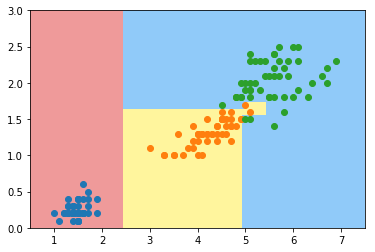

In [162]:
# 绘制分类决策边界  

def plot_decision_boundary(model, axis):
    
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]

    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)

    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    
    plt.contourf(x0, x1, zz, linewidth=5, cmap=custom_cmap)
    
plot_decision_boundary(dt_clf, [0.5, 7.5, 0, 3])
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])
plt.scatter(X[y==2, 0], X[y==2, 1])
plt.show()

从上图中可以看出决策树可以大致的进行数据分类，但是上图中黄色部分的边界明显发生了过拟合，可以通过剪枝来减少过拟合的程度